In [98]:
#imports
import os
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import tensorflow as tf

In [99]:
# List of FAANG stocks with their corresponding ticker symbols
faang_stocks = {
    "Facebook (Meta)": "META",
    "Amazon": "AMZN",
    "Apple": "AAPL",
    "Netflix": "NFLX",
    "Google (Alphabet)": "GOOGL",
}


In [100]:
# Loop through FAANG stocks and process each one
for stock_name, ticker_symbol in faang_stocks.items():
    
    # Define the ticker using the selected stock
    ticker = yf.Ticker(ticker_symbol)
    
    # Get historical data for the maximum available period
    historical_data = ticker.history(period="max")
    
    if not historical_data.empty:
    # Save the historical data as CSV
        csv_file_path = f"stock_data_csv/{ticker_symbol}_max.csv"

    # Check if the file already exists
    if not os.path.exists(csv_file_path):
        # Data cleaning: Drop NaN values
        historical_data.dropna(inplace=True)

        # Save the cleaned data to CSV
        historical_data.to_csv(csv_file_path)
        print(f"Data saved for {stock_name} as {csv_file_path}")
    else:
        print(f"File {csv_file_path} already exists. Skipping save.")

File stock_data_csv/META_max.csv already exists. Skipping save.
File stock_data_csv/AMZN_max.csv already exists. Skipping save.
File stock_data_csv/AAPL_max.csv already exists. Skipping save.
File stock_data_csv/NFLX_max.csv already exists. Skipping save.
File stock_data_csv/GOOGL_max.csv already exists. Skipping save.


In [101]:
# Define the ticker using the selected stock
ticker = yf.Ticker("META")

# Get historical data for the maximum available period
historical_data = ticker.history(period="max")

In [102]:
# Close prices are used for prediction
# data = historical_data[['Open', 'High', 'Low', 'Close', 'Volume']]
# labels = historical_data[['Close']]
data = historical_data[['Close']]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
# Split into training and testing datasets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

Time series data, such as stock prices, is inherently ordered, and the sequence of data points matters. Using train_test_split, which randomly shuffles and splits the data, would break this temporal relationship. For time series data, we typically use a chronological split (e.g., training on the first 80% of the data and testing on the next 20%) to maintain the sequence of events.

In [103]:
# Create sequences
def create_sequences(data, seq_length=1):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Set sequence length
seq_length = 60  # Using last 60 days to predict the next day

# Create sequences from the training and testing datasets
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Debugging: Print the shapes before reshaping
print(f"x_train shape before reshaping: {x_train.shape}")
print(f"x_test shape before reshaping: {x_test.shape}")

# Reshape the data for the LSTM model (samples, time steps, features)
try:
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    print("Reshaping successful")
except ValueError as e:
    print(f"Error during reshaping: {e}")
    print(f"x_train size: {x_train.size}, x_train.shape[0] * 60 * 1: {x_train.shape[0] * 60 * 1}")



x_train shape before reshaping: (2420, 60, 1)
x_test shape before reshaping: (560, 60, 1)
Reshaping successful


In [104]:
# Build the TensorFlow LSTM Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
# Debugging: Print the shapes before training
print(f"x_train shape: {x_train.shape}")  # Should be (num_samples, seq_length, 1)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples,)

# Check the number of samples in both
assert x_train.shape[0] == y_train.shape[0], "Number of samples in x_train and y_train do not match!"
assert x_train.shape[2] == 1, "The last dimension (features) should be 1."

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=500)

# Predictions from the LSTM model
lstm_predictions = model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Actual values for comparison
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Score the LSTM model using R2 score
lstm_r2_score = r2_score(actual_prices, lstm_predictions)
print(f"LSTM R² score for {stock_name}: {lstm_r2_score:.4f}")

# Flatten the data for scikit-learn models
flat_train_data = train_data[seq_length:].reshape(-1, 1)
flat_test_data = test_data[seq_length:].reshape(-1, 1)

x_train shape: (2420, 60, 1)
y_train shape: (2420, 1)
Epoch 1/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0153
Epoch 2/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4820e-04
Epoch 3/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7762e-04
Epoch 4/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6839e-04
Epoch 5/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2080e-04
Epoch 6/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3580e-04
Epoch 7/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2959e-04
Epoch 8/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0271e-04
Epoch 9/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9901e-04
Epoch 10/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4549e-04
Epoch 11/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8374e-04
Epoch 12/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1043e-04
Epoch 13/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6196e-04
Epoch 14/500
76/76 ━━━━

In [106]:
# Models to be tested
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100),
    "Support Vector Regressor": SVR(kernel='rbf')
}

# Train and evaluate each model
for model_name, model_instance in models.items():
    model_instance.fit(flat_train_data, y_train)
    predictions = model_instance.predict(flat_test_data)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    # Compute R² score for the model
    r2 = r2_score(actual_prices, predictions)
    print(f"{model_name} R² score for {stock_name}: {r2:.4f}")

Linear Regression R² score for Google (Alphabet): 1.0000
Decision Tree Regressor R² score for Google (Alphabet): 0.8146
Random Forest Regressor R² score for Google (Alphabet): 0.8137
Support Vector Regressor R² score for Google (Alphabet): -0.0681


c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
model.save('models/best_model_meta.keras')

In [108]:
from joblib import dump

# After fitting the scaler
dump(scaler, 'scalers/scaler_meta.gz')

['scalers/scaler_meta.gz']

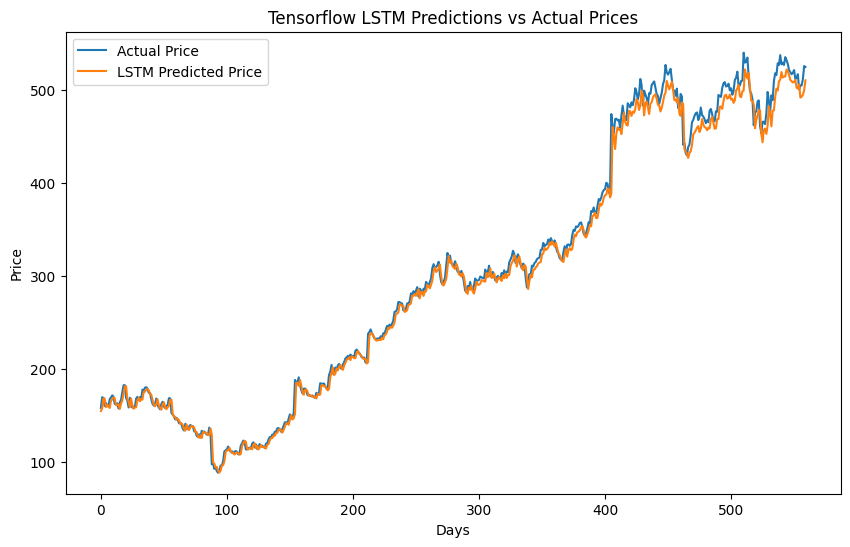

In [109]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(lstm_predictions, label="LSTM Predicted Price")
plt.title("Tensorflow LSTM Predictions vs Actual Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()
